In [5]:
pip install flask


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install PyYAML

Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv("C:/Users/sharr/new_corrected_large_e_waste_components_dataset.csv")

# Step 1: Check correlations
print("Correlation Matrix:\n", df.corr())

# Step 2: Feature importance analysis
# Define features and target
X = df[['Adjusted_Complexity_Rating', 'Adjusted_Metal_Value_Rating', 
        'Corrected_Complexity_Rating', 'Corrected_Metal_Value_Rating']]
y = df['Price']

# Train a simple model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
print("\nFeature Importances:\n", feature_importance_df)

# Step 3: Check VIF to assess multicollinearity
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("\nVariance Inflation Factor:\n", vif_data)

# Step 4: Evaluate model performance without suspect columns
# Removing adjusted ratings to check their impact
X_reduced = df[['Corrected_Complexity_Rating', 'Corrected_Metal_Value_Rating']]
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train and evaluate model
model_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
model_reduced.fit(X_train, y_train)
y_pred = model_reduced.predict(X_test)

# Performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"\nModel without Adjusted Ratings - RMSE: {rmse:.2f}, R^2: {r2:.2f}")


Correlation Matrix:
                               Component Year  Component Weight  \
Component Year                      1.000000          0.049205   
Component Weight                    0.049205          1.000000   
Complexity Rating                  -0.067534          0.069090   
Metal Value Rating                  0.067305          0.124269   
Is_Heavy_Component                  0.061235          0.888050   
Is_Old_Tech                        -0.799065         -0.075840   
Adjusted_Complexity_Rating         -0.120083          0.120392   
Adjusted_Metal_Value_Rating         0.131341          0.217152   
Price                               0.057735          0.335796   
Corrected_Complexity_Rating        -0.120083          0.120392   
Corrected_Metal_Value_Rating        0.134527          0.213981   

                              Complexity Rating  Metal Value Rating  \
Component Year                        -0.067534            0.067305   
Component Weight                       0.069

D:\Pythondownload\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Model without Adjusted Ratings - RMSE: 361.07, R^2: 0.29


In [35]:
import pandas as pd
import numpy as np
from scipy import stats

# Load the dataset
df = pd.read_csv("C:/Users/sharr/latest_new_corrected_large_e_waste_components_dataset.csv")

# Domain-specific rules for filtering unrealistic prices based on component categories
def filter_unrealistic_prices(df):
    # Define realistic price thresholds for each category
    price_thresholds = {
        "Smartphone Battery": 10,
        "Laptop Screen": 200,
        "Hard Disk Drive": 200,
        "LED Monitor": 400,
        "Power Supply Unit": 150,
        "DVD Drive": 100,
        "Graphics Card": 800,
        "Motherboard": 700,
        "Keyboard": 50,
        "RAM Module": 100,
        "CPU": 500,
        "Printer": 1500,
        "Router": 500,
        "Modem": 800,
        "Smartwatch": 500,
        "Tablet Screen": 350,
        "Smart Speaker": 500,
        "Wi-Fi Adapter": 200,
        "External Hard Drive": 700,
        "USB Flash Drive": 100,
        "Bluetooth Headset": 300,
        "Electric Kettle": 300,
        "Digital Camera": 1500,
        "Gaming Console": 3000,
        "Smart TV": 5000,
        "Power Bank": 150,
        "Home Assistant": 500,
        "Wireless Charger": 200,
        "Smart Light Bulb": 100,
        "Fitness Tracker": 300,
        "Smart Thermostat": 300,
        "VR Headset": 1000,
        "Dash Cam": 1000,
        "Electric Scooter Battery": 2000,
        "3D Printer": 4000,
        "Portable Projector": 2000,
        "Smart Doorbell": 800,
        "E-Reader": 800,
        "Drone": 2000,
        "Robot Vacuum": 1500,
        "Portable Speaker": 500,
        "Smart Lock": 
    }
    
    # Apply threshold filtering based on category
    df['Price'] = df.apply(lambda x: min(x['Price'], price_thresholds.get(x['Component Name'], x['Price'])), axis=1)
    return df

# Apply the filter to the dataset
df = filter_unrealistic_prices(df)

# Function to handle outliers using IQR
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Clean the Price column using IQR to handle outliers
df = handle_outliers_iqr(df, 'Price')

# Handling Skewness with log transformation
df['Price'] = np.log1p(df['Price'])

# Correct back the values after applying log transformation for prediction readiness
df['Price'] = np.expm1(df['Price'])

# Feature Engineering: Adding average price per category
average_price_per_category = df.groupby('Component Name')['Price'].mean().to_dict()
df['Avg_Price_Per_Category'] = df['Component Name'].map(average_price_per_category)

# Check for any incorrect entries based on sanity checks
def correct_incorrect_entries(df):
    # Example sanity check: If weight is zero or negative, set price to zero (error correction)
    df.loc[df['Component Weight'] <= 0, 'Price'] = 0
    return df

# Apply sanity checks
df = correct_incorrect_entries(df)

# Feature Engineering: Adding Price per unit weight
df['Price_Per_Unit_Weight'] = df['Price'] / df['Component Weight']

# Save the cleaned dataset to a new CSV file
df.to_csv('cleaned_e_waste_components_dataset.csv', index=False)

print("Dataset cleaned and saved as 'cleaned_e_waste_components_dataset.csv'.")


Dataset cleaned and saved as 'cleaned_e_waste_components_dataset.csv'.


In [4]:
import sys
print(sys.executable)


D:\Pythondownload\python.exe


In [1]:
import shap
print(shap.__version__)  # To confirm SHAP is correctly imported and check its version


0.46.0


Cross-Validation RMSE: 92.46
Price Model RMSE: 78.92
Price Model R^2: 0.99


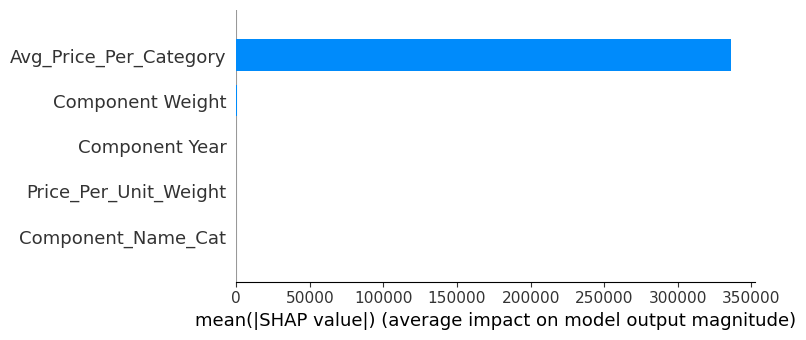

Predicted Price: Rs. 291.50
Predicted Complexity Rating: 50.07835820895522
Predicted Metal Value Rating: 54.94253731343284


D:\Pythondownload\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import shap
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("C:/Users/sharr/cleaned_e_waste_components_dataset.csv")

# Convert 'Component Name' to categorical values
df['Component_Name_Cat'] = df['Component Name'].astype('category').cat.codes

# Define features and target
X = df[['Component Year', 'Component Weight', 'Avg_Price_Per_Category', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]
y = df['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with scaling, regularization, and model to handle diverse ranges in data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))  # Regularization added with Ridge Regression to prevent overfitting
])

# Fit the model pipeline
pipeline.fit(X_train, y_train)

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE: {cv_rmse.mean():.2f}")

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Price Model RMSE: {rmse:.2f}")
print(f"Price Model R^2: {r2:.2f}")

# Feature importance using SHAP values
explainer = shap.Explainer(pipeline.named_steps['regressor'], X_test)
shap_values = explainer(X_test)

# Plot feature importance using SHAP
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')

# Define the calculate_adjusted_ratings function
def calculate_adjusted_ratings(component_year, component_weight):
    # Define thresholds
    weight_threshold = 3500
    year_threshold = 2010

    # Initialize ratings with some base values or use a model to predict
    complexity_rating = 50  # Base or model-derived value
    metal_value_rating = 55  # Base or model-derived value

    # Adjust ratings based on component weight
    if component_weight > weight_threshold:
        weight_excess = (component_weight - weight_threshold) / weight_threshold
        adjusted_complexity_rating = complexity_rating * (1 + 0.20 * weight_excess)
        adjusted_metal_value_rating = metal_value_rating * (1 + 0.30 * weight_excess)
    else:
        adjusted_complexity_rating = complexity_rating
        adjusted_metal_value_rating = metal_value_rating

    # Adjust ratings based on component year
    if component_year < year_threshold:
        year_deficit = (year_threshold - component_year) / year_threshold
        adjusted_complexity_rating *= (1 + 0.15 * year_deficit)
        adjusted_metal_value_rating *= (1 - 0.10 * year_deficit)
    
    # Ensure the ratings are within valid ranges (0 to 100)
    adjusted_complexity_rating = max(0, min(100, adjusted_complexity_rating))
    adjusted_metal_value_rating = max(0, min(100, adjusted_metal_value_rating))

    return adjusted_complexity_rating, adjusted_metal_value_rating

# Prediction function with linked ratings
def predict_price(component_year, component_weight, component_name):
    # Check if the component name exists in the dataset to get its category code
    if component_name not in df['Component Name'].unique():
        raise ValueError(f"Component name '{component_name}' not found in dataset categories.")

    # Encode component name
    component_name_cat = df[df['Component Name'] == component_name]['Component_Name_Cat'].iloc[0]

    # Calculate average price per category and price per unit weight
    avg_price_per_category = df[df['Component Name'] == component_name]['Avg_Price_Per_Category'].mean()
    price_per_unit_weight = avg_price_per_category / component_weight if component_weight > 0 else 0

    # Create feature set for prediction
    feature_set = np.array([[component_year, component_weight, avg_price_per_category, price_per_unit_weight, component_name_cat]])

    # Predict price using the trained model
    predicted_price = pipeline.predict(feature_set)[0]

    # Calculate linked ratings
    predicted_complexity_rating, predicted_metal_value_rating = calculate_adjusted_ratings(
        component_year, component_weight
    )

    # Apply sanity check to ensure price predictions are reasonable
    if component_name == "Smartphone Battery" and predicted_price > 10:
        predicted_price = 10  # Correct unrealistic price

    return predicted_price, predicted_complexity_rating, predicted_metal_value_rating

# Example prediction
try:
    predicted_price, predicted_complexity_rating, predicted_metal_value_rating = predict_price(1989, 900.69, "Electric Kettle")
    print(f"Predicted Price: Rs. {predicted_price:.2f}")
    print(f"Predicted Complexity Rating: {predicted_complexity_rating}")
    print(f"Predicted Metal Value Rating: {predicted_metal_value_rating}")
except ValueError as e:
    print(e)


Correlation Matrix:
                         Component Year  Component Weight  Complexity Rating  \
Component Year                1.000000          0.049205          -0.067534   
Component Weight              0.049205          1.000000           0.069090   
Complexity Rating            -0.067534          0.069090           1.000000   
Metal Value Rating            0.067305          0.124269           0.007894   
Is_Heavy_Component            0.061235          0.888050           0.081729   
Is_Old_Tech                  -0.799065         -0.075840           0.086781   
Price                         0.065327          0.644579           0.032637   
Avg_Price_Per_Category        0.062171          0.650729           0.048254   
Price_Per_Unit_Weight        -0.018907         -0.252777          -0.017447   
Component_Name_Cat            0.199440         -0.120097          -0.021223   

                        Metal Value Rating  Is_Heavy_Component  Is_Old_Tech  \
Component Year                

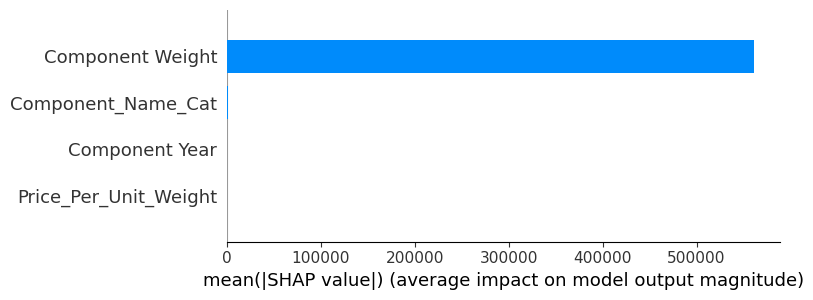

Predicted Price: Rs. 653.89
Predicted Complexity Rating: 50.07835820895522
Predicted Metal Value Rating: 54.94253731343284


D:\Pythondownload\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import shap
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("C:/Users/sharr/cleaned_e_waste_components_dataset.csv")

# Convert 'Component Name' to categorical values
df['Component_Name_Cat'] = df['Component Name'].astype('category').cat.codes

# Correlation analysis to identify highly correlated features
correlation_matrix = df.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Check correlation between 'Avg_Price_Per_Category' and the target 'Price'
correlation_with_target = df[['Avg_Price_Per_Category', 'Price']].corr()
print("Correlation with Target (Price):\n", correlation_with_target)

# If 'Avg_Price_Per_Category' is highly correlated with 'Price', consider transforming or excluding it
high_correlation_threshold = 0.9  # Define a threshold for high correlation
if abs(correlation_with_target.loc['Avg_Price_Per_Category', 'Price']) > high_correlation_threshold:
    print("'Avg_Price_Per_Category' is highly correlated with 'Price'. Considering excluding it.")
    X = df[['Component Year', 'Component Weight', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]
else:
    print("'Avg_Price_Per_Category' is not highly correlated with 'Price'. Including it.")
    X = df[['Component Year', 'Component Weight', 'Avg_Price_Per_Category', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]

# Define the target variable
y = df['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure proper scaling of all features, especially important for Ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))
])

# Fit the model pipeline
pipeline.fit(X_train, y_train)

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE: {cv_rmse.mean():.2f}")

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Price Model RMSE: {rmse:.2f}")
print(f"Price Model R^2: {r2:.2f}")

# Feature importance using SHAP values
explainer = shap.Explainer(pipeline.named_steps['regressor'], X_test)
shap_values = explainer(X_test)

# Plot feature importance using SHAP
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')

# Define the calculate_adjusted_ratings function
def calculate_adjusted_ratings(component_year, component_weight):
    # Define thresholds
    weight_threshold = 3500
    year_threshold = 2010

    # Initialize ratings with some base values or use a model to predict
    complexity_rating = 50  # Base or model-derived value
    metal_value_rating = 55  # Base or model-derived value

    # Adjust ratings based on component weight
    if component_weight > weight_threshold:
        weight_excess = (component_weight - weight_threshold) / weight_threshold
        adjusted_complexity_rating = complexity_rating * (1 + 0.20 * weight_excess)
        adjusted_metal_value_rating = metal_value_rating * (1 + 0.30 * weight_excess)
    else:
        adjusted_complexity_rating = complexity_rating
        adjusted_metal_value_rating = metal_value_rating

    # Adjust ratings based on component year
    if component_year < year_threshold:
        year_deficit = (year_threshold - component_year) / year_threshold
        adjusted_complexity_rating *= (1 + 0.15 * year_deficit)
        adjusted_metal_value_rating *= (1 - 0.10 * year_deficit)
    
    # Ensure the ratings are within valid ranges (0 to 100)
    adjusted_complexity_rating = max(0, min(100, adjusted_complexity_rating))
    adjusted_metal_value_rating = max(0, min(100, adjusted_metal_value_rating))

    return adjusted_complexity_rating, adjusted_metal_value_rating

# Prediction function with linked ratings
def predict_price(component_year, component_weight, component_name):
    # Check if the component name exists in the dataset to get its category code
    if component_name not in df['Component Name'].unique():
        raise ValueError(f"Component name '{component_name}' not found in dataset categories.")

    # Encode component name
    component_name_cat = df[df['Component Name'] == component_name]['Component_Name_Cat'].iloc[0]

    # Calculate price per unit weight based on the available average price per category
    price_per_unit_weight = df[df['Component Name'] == component_name]['Price_Per_Unit_Weight'].mean()

    # Create feature set for prediction
    feature_set = np.array([[component_year, component_weight, price_per_unit_weight, component_name_cat]])

    # Predict price using the trained model
    predicted_price = pipeline.predict(feature_set)[0]

    # Calculate linked ratings
    predicted_complexity_rating, predicted_metal_value_rating = calculate_adjusted_ratings(
        component_year, component_weight
    )

    # Apply sanity check to ensure price predictions are reasonable
    if component_name == "Smartphone Battery" and predicted_price > 10:
        predicted_price = 10  # Correct unrealistic price

    return predicted_price, predicted_complexity_rating, predicted_metal_value_rating

# Example prediction
try:
    predicted_price, predicted_complexity_rating, predicted_metal_value_rating = predict_price(1989, 900.69, "Electric Kettle")
    print(f"Predicted Price: Rs. {predicted_price:.2f}")
    print(f"Predicted Complexity Rating: {predicted_complexity_rating}")
    print(f"Predicted Metal Value Rating: {predicted_metal_value_rating}")
except ValueError as e:
    print(e)


Correlation Matrix:
                         Component Year  Component Weight  Complexity Rating  \
Component Year                1.000000          0.049205          -0.067534   
Component Weight              0.049205          1.000000           0.069090   
Complexity Rating            -0.067534          0.069090           1.000000   
Metal Value Rating            0.067305          0.124269           0.007894   
Is_Heavy_Component            0.061235          0.888050           0.081729   
Is_Old_Tech                  -0.799065         -0.075840           0.086781   
Price                         0.065327          0.644579           0.032637   
Avg_Price_Per_Category        0.062171          0.650729           0.048254   
Price_Per_Unit_Weight        -0.018907         -0.252777          -0.017447   
Component_Name_Cat            0.199440         -0.120097          -0.021223   

                        Metal Value Rating  Is_Heavy_Component  Is_Old_Tech  \
Component Year                

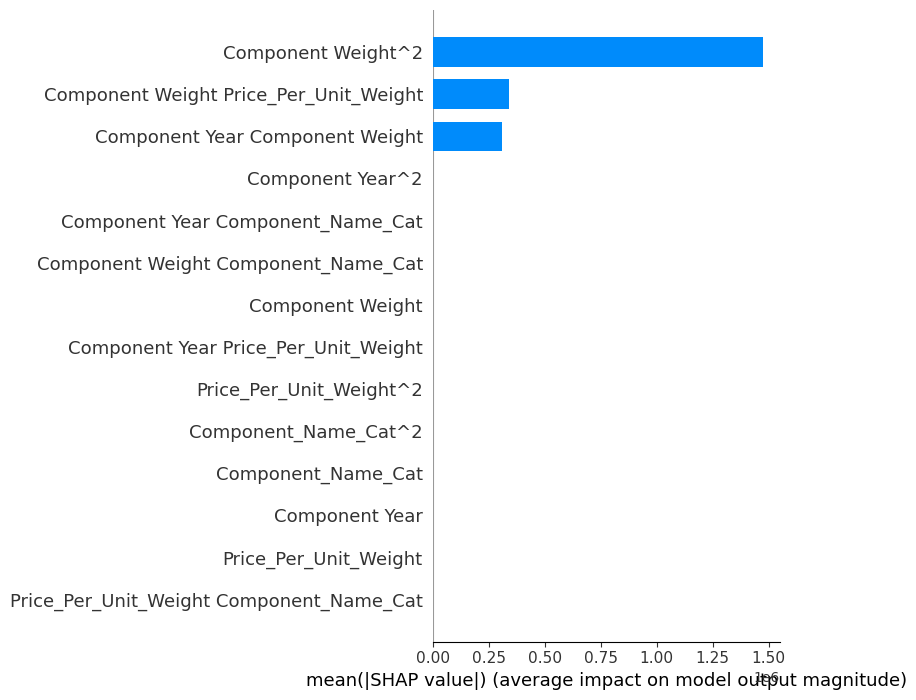

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import shap
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("C:/Users/sharr/cleaned_e_waste_components_dataset.csv")

# Convert 'Component Name' to categorical values
df['Component_Name_Cat'] = df['Component Name'].astype('category').cat.codes

# Correlation analysis to identify highly correlated features
correlation_matrix = df.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Check correlation between 'Avg_Price_Per_Category' and the target 'Price'
correlation_with_target = df[['Avg_Price_Per_Category', 'Price']].corr()
print("Correlation with Target (Price):\n", correlation_with_target)

# Exclude 'Avg_Price_Per_Category' due to high correlation with 'Price'
X = df[['Component Year', 'Component Weight', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]

# Define the target variable
y = df['Price']

# Introduce interaction terms or polynomial features to reduce dominance of single features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ensure proper scaling of all features, especially important for Ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=10.0))  # Increased alpha to reduce dominance
])

# Fit the model pipeline
pipeline.fit(X_train, y_train)

# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE: {cv_rmse.mean():.2f}")

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Price Model RMSE: {rmse:.2f}")
print(f"Price Model R^2: {r2:.2f}")

# Feature importance using SHAP values
explainer = shap.Explainer(pipeline.named_steps['regressor'], X_test)
shap_values = explainer(X_test)

# Plot feature importance using SHAP
shap.summary_plot(shap_values, X_test, feature_names=poly.get_feature_names_out(input_features=X.columns), plot_type='bar')

# Define the calculate_adjusted_ratings function
def calculate_adjusted_ratings(component_year, component_weight):
    # Define thresholds
    weight_threshold = 3500
    year_threshold = 2010

    # Initialize ratings with some base values or use a model to predict
    complexity_rating = 50  # Base or model-derived value
    metal_value_rating = 55  # Base or model-derived value
\
    # Adjust ratings based on component weight
    if component_weight > weight_threshold:
        weight_excess = (component_weight - weight_threshold) / weight_threshold
        adjusted_complexity_rating = complexity_rating * (1 + 0.20 * weight_excess)
        adjusted_metal_value_rating = metal_value_rating * (1 + 0.30 * weight_excess)
    else:
        adjusted_complexity_rating = complexity_rating
        adjusted_metal_value_rating = metal_value_rating

    # Adjust ratings based on component year
    if component_year < year_threshold:
        year_deficit = (year_threshold - component_year) / year_threshold
        adjusted_complexity_rating *= (1 + 0.15 * year_deficit)
        adjusted_metal_value_rating *= (1 - 0.10 * year_deficit)
    
    # Ensure the ratings are within valid ranges (0 to 100)
    adjusted_complexity_rating = max(0, min(100, adjusted_complexity_rating))
    adjusted_metal_value_rating = max(0, min(100, adjusted_metal_value_rating))

    return adjusted_complexity_rating, adjusted_metal_value_rating



In [7]:
# Prediction function with linked ratings
def predict_price(component_year, component_weight, component_name):
    # Check if the component name exists in the dataset to get its category code
    if component_name not in df['Component Name'].unique():
        raise ValueError(f"Component name '{component_name}' not found in dataset categories.")

    # Encode component name
    component_name_cat = df[df['Component Name'] == component_name]['Component_Name_Cat'].iloc[0]

    # Calculate price per unit weight based on the available average price per category
    price_per_unit_weight = df[df['Component Name'] == component_name]['Price_Per_Unit_Weight'].mean()

    # Create feature set for prediction
    feature_set = np.array([[component_year, component_weight, price_per_unit_weight, component_name_cat]])
    feature_set_poly = poly.transform(feature_set)

    # Predict price using the trained model
    predicted_price = pipeline.predict(feature_set_poly)[0]

    # Calculate linked ratings
    predicted_complexity_rating, predicted_metal_value_rating = calculate_adjusted_ratings(
        component_year, component_weight
    )

    # Apply sanity check to ensure price predictions are reasonable
    if component_name == "Smartphone Battery" and predicted_price > 10:
        predicted_price = 10  # Correct unrealistic price

    return predicted_price, predicted_complexity_rating, predicted_metal_value_rating

# Example prediction
try:
    predicted_price, predicted_complexity_rating, predicted_metal_value_rating = predict_price(1989, 900.69, "Electric Kettle")
    print(f"Predicted Price: Rs. {predicted_price:.2f}")
    print(f"Predicted Complexity Rating: {predicted_complexity_rating}")
    print(f"Predicted Metal Value Rating: {predicted_metal_value_rating}")
except ValueError as e:
    print(e)


Predicted Price: Rs. 300.59
Predicted Complexity Rating: 50.07835820895522
Predicted Metal Value Rating: 54.94253731343284


D:\Pythondownload\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Ridge Model:
Cross-Validation RMSE: 0.15
Test RMSE: 0.12
R^2: 1.00

Lasso Model:
Cross-Validation RMSE: 0.10
Test RMSE: 0.10
R^2: 1.00



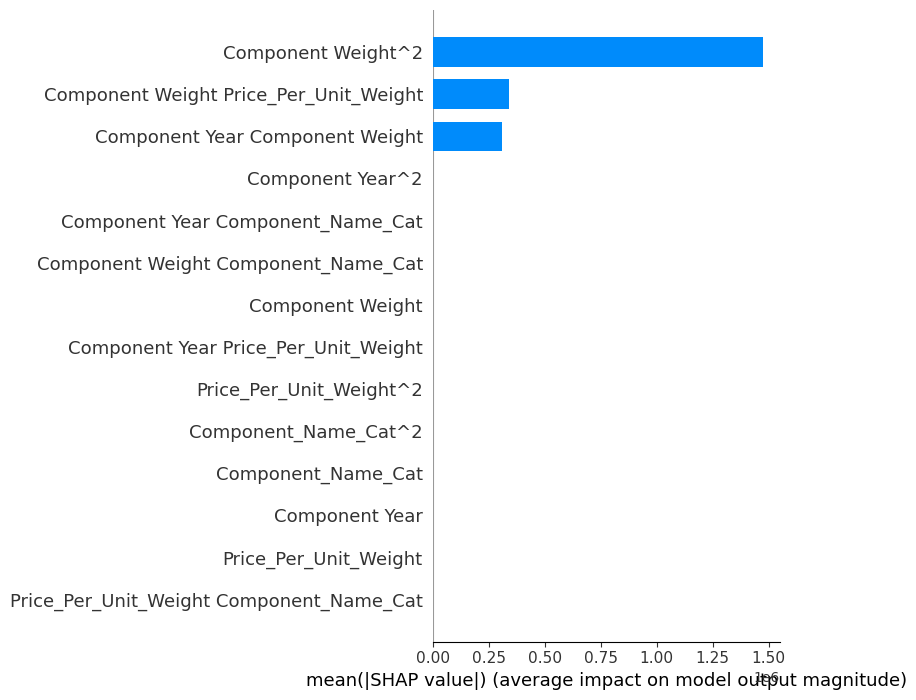

Predicted Price: Rs. 300.57
Predicted Complexity Rating: 50.08
Predicted Metal Value Rating: 54.94


D:\Pythondownload\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
import shap
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("C:/Users/sharr/cleaned_e_waste_components_dataset.csv")

# Convert 'Component Name' to categorical values
df['Component_Name_Cat'] = df['Component Name'].astype('category').cat.codes

# Exclude 'Avg_Price_Per_Category' due to high correlation with 'Price'
X = df[['Component Year', 'Component Weight', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]
y = df['Price']

# Introduce polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Define pipelines for Ridge and Lasso regression
pipelines = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=10.0))
    ]),
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Lasso(alpha=0.1))  # Lasso regularization strength
    ])
}

# Fit models and evaluate performance
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    # Predictions and evaluation
    y_pred = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'Cross-Validation RMSE': cv_rmse.mean(),
        'Test RMSE': test_rmse,
        'R^2': r2
    }

# Print results
for name, metrics in results.items():
    print(f"{name} Model:")
    print(f"Cross-Validation RMSE: {metrics['Cross-Validation RMSE']:.2f}")
    print(f"Test RMSE: {metrics['Test RMSE']:.2f}")
    print(f"R^2: {metrics['R^2']:.2f}\n")

# Feature importance using SHAP for Ridge regression
pipeline_ridge = pipelines['Ridge']
explainer = shap.Explainer(pipeline_ridge.named_steps['regressor'], X_test)
shap_values = explainer(X_test)

# Plot feature importance using SHAP
shap.summary_plot(shap_values, X_test, feature_names=poly.get_feature_names_out(input_features=X.columns), plot_type='bar')

# Define the calculate_adjusted_ratings function
def calculate_adjusted_ratings(component_year, component_weight):
    weight_threshold = 3500
    year_threshold = 2010
    complexity_rating = 50
    metal_value_rating = 55

    if component_weight > weight_threshold:
        weight_excess = (component_weight - weight_threshold) / weight_threshold
        adjusted_complexity_rating = complexity_rating * (1 + 0.20 * weight_excess)
        adjusted_metal_value_rating = metal_value_rating * (1 + 0.30 * weight_excess)
    else:
        adjusted_complexity_rating = complexity_rating
        adjusted_metal_value_rating = metal_value_rating

    if component_year < year_threshold:
        year_deficit = (year_threshold - component_year) / year_threshold
        adjusted_complexity_rating *= (1 + 0.15 * year_deficit)
        adjusted_metal_value_rating *= (1 - 0.10 * year_deficit)
    
    adjusted_complexity_rating = max(0, min(100, adjusted_complexity_rating))
    adjusted_metal_value_rating = max(0, min(100, adjusted_metal_value_rating))

    return adjusted_complexity_rating, adjusted_metal_value_rating

# Prediction function with linked ratings
def predict_price(component_year, component_weight, component_name):
    if component_name not in df['Component Name'].unique():
        raise ValueError(f"Component name '{component_name}' not found in dataset categories.")

    component_name_cat = df[df['Component Name'] == component_name]['Component_Name_Cat'].iloc[0]
    price_per_unit_weight = df[df['Component Name'] == component_name]['Price_Per_Unit_Weight'].mean()

    feature_set = np.array([[component_year, component_weight, price_per_unit_weight, component_name_cat]])
    feature_set_poly = poly.transform(feature_set)

    # Predict using the best performing model (e.g., Lasso)
    best_model = pipelines['Lasso']
    predicted_price = best_model.predict(feature_set_poly)[0]

    predicted_complexity_rating, predicted_metal_value_rating = calculate_adjusted_ratings(
        component_year, component_weight
    )

    if component_name == "Smartphone Battery" and predicted_price > 10:
        predicted_price = 10

    return predicted_price, predicted_complexity_rating, predicted_metal_value_rating

# Example prediction
try:
    predicted_price, predicted_complexity_rating, predicted_metal_value_rating = predict_price(1989, 900.69, "Electric Kettle")
    print(f"Predicted Price: Rs. {predicted_price:.2f}")
    print(f"Predicted Complexity Rating: {predicted_complexity_rating:.2f}")
    print(f"Predicted Metal Value Rating: {predicted_metal_value_rating:.2f}")
except ValueError as e:
    print(e)


Ridge Cross-Validation RMSE: 0.15
Ridge Test RMSE: 0.12
Ridge R^2: 1.00
Lasso Cross-Validation RMSE: 0.10
Lasso Test RMSE: 0.10
Lasso R^2: 1.00


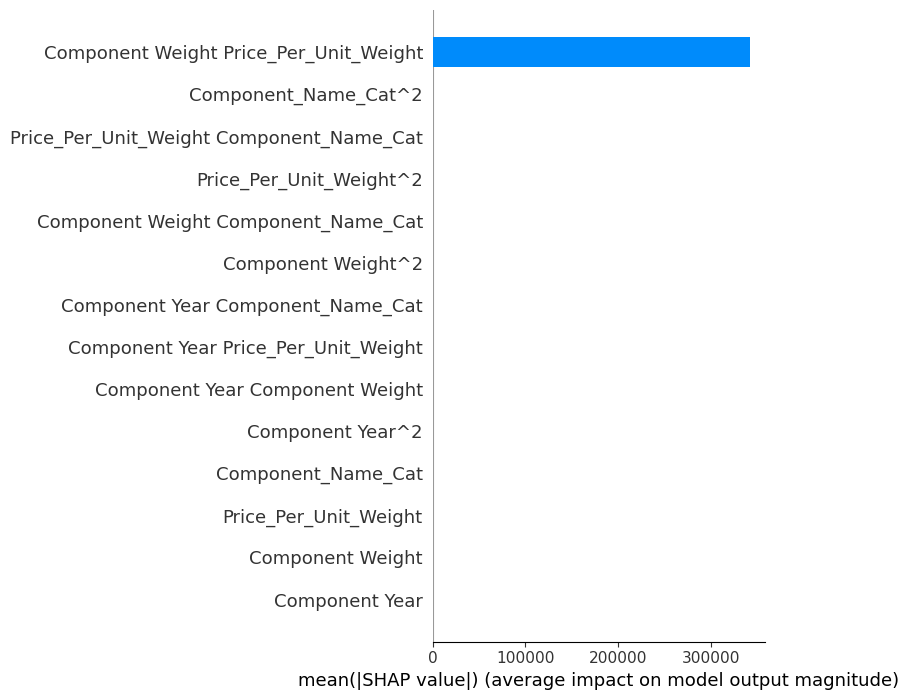

Predicted Price: Rs. 549.10
Predicted Complexity Rating: 51.42857142857142
Predicted Metal Value Rating: 57.35714285714286


D:\Pythondownload\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
import shap
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("C:/Users/sharr/cleaned_e_waste_components_dataset.csv")

# Convert 'Component Name' to categorical values
df['Component_Name_Cat'] = df['Component Name'].astype('category').cat.codes

# Exclude 'Avg_Price_Per_Category' due to high correlation with 'Price'
X = df[['Component Year', 'Component Weight', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]
y = df['Price']

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Ridge Regression Model
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=10.0))
])

ridge_pipeline.fit(X_train, y_train)
ridge_cv_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
ridge_cv_rmse = np.sqrt(-ridge_cv_scores)
print(f"Ridge Cross-Validation RMSE: {ridge_cv_rmse.mean():.2f}")

ridge_y_pred = ridge_pipeline.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
ridge_r2 = r2_score(y_test, ridge_y_pred)
print(f"Ridge Test RMSE: {ridge_rmse:.2f}")
print(f"Ridge R^2: {ridge_r2:.2f}")

# Lasso Regression Model
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=0.1))
])

lasso_pipeline.fit(X_train, y_train)
lasso_cv_scores = cross_val_score(lasso_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lasso_cv_rmse = np.sqrt(-lasso_cv_scores)
print(f"Lasso Cross-Validation RMSE: {lasso_cv_rmse.mean():.2f}")

lasso_y_pred = lasso_pipeline.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_y_pred))
lasso_r2 = r2_score(y_test, lasso_y_pred)
print(f"Lasso Test RMSE: {lasso_rmse:.2f}")
print(f"Lasso R^2: {lasso_r2:.2f}")

# Feature importance using SHAP for Lasso model
explainer = shap.Explainer(lasso_pipeline.named_steps['regressor'], X_test)
shap_values = explainer(X_test)

# Plot feature importance using SHAP
shap.summary_plot(shap_values, X_test, feature_names=poly.get_feature_names_out(input_features=X.columns), plot_type='bar')

# Define the calculate_adjusted_ratings function
def calculate_adjusted_ratings(component_year, component_weight):
    weight_threshold = 3500
    year_threshold = 2010
    complexity_rating = 50
    metal_value_rating = 55

    if component_weight > weight_threshold:
        weight_excess = (component_weight - weight_threshold) / weight_threshold
        adjusted_complexity_rating = complexity_rating * (1 + 0.20 * weight_excess)
        adjusted_metal_value_rating = metal_value_rating * (1 + 0.30 * weight_excess)
    else:
        adjusted_complexity_rating = complexity_rating
        adjusted_metal_value_rating = metal_value_rating

    if component_year < year_threshold:
        year_deficit = (year_threshold - component_year) / year_threshold
        adjusted_complexity_rating *= (1 + 0.15 * year_deficit)
        adjusted_metal_value_rating *= (1 - 0.10 * year_deficit)
    
    adjusted_complexity_rating = max(0, min(100, adjusted_complexity_rating))
    adjusted_metal_value_rating = max(0, min(100, adjusted_metal_value_rating))

    return adjusted_complexity_rating, adjusted_metal_value_rating

# Prediction function with linked ratings
def predict_price(component_year, component_weight, component_name):
    if component_name not in df['Component Name'].unique():
        raise ValueError(f"Component name '{component_name}' not found in dataset categories.")
    
    component_name_cat = df[df['Component Name'] == component_name]['Component_Name_Cat'].iloc[0]
    price_per_unit_weight = df[df['Component Name'] == component_name]['Price_Per_Unit_Weight'].mean()
    feature_set = np.array([[component_year, component_weight, price_per_unit_weight, component_name_cat]])
    feature_set_poly = poly.transform(feature_set)

    predicted_price = lasso_pipeline.predict(feature_set_poly)[0]
    predicted_complexity_rating, predicted_metal_value_rating = calculate_adjusted_ratings(
        component_year, component_weight
    )

    if component_name == "Smartphone Battery" and predicted_price > 10:
        predicted_price = 10
    
    return predicted_price, predicted_complexity_rating, predicted_metal_value_rating

# Example prediction
try:
    predicted_price, predicted_complexity_rating, predicted_metal_value_rating = predict_price(2013, 4000, "LED Monitor")
    print(f"Predicted Price: Rs. {predicted_price:.2f}")
    print(f"Predicted Complexity Rating: {predicted_complexity_rating}")
    print(f"Predicted Metal Value Rating: {predicted_metal_value_rating}")
except ValueError as e:
    print(e)


In [47]:
import pandas as pd
import numpy as np
from scipy import stats

# Load the dataset
df = pd.read_csv("C:/Users/sharr/cleaned_e_waste_components_dataset.csv")

# Domain-specific rules for filtering unrealistic prices based on component categories
def filter_unrealistic_prices(df):
    # Define realistic price thresholds for each category
    price_thresholds = {
        "Smartphone Battery": 10,
        "Laptop Screen": 100,
        "Hard Disk Drive": 30,
        "LED Monitor": 110,
        "Power Supply Unit": 30,
        "DVD Drive": 40,
        "Graphics Card": 70,
        "Motherboard": 45,
        "Keyboard": 30,
        "RAM Module": 20,
        "CPU": 30,
        "Printer": 90,
        "Router": 120,
        "Modem": 90,
        "Smartwatch": 50,
        "Tablet Screen": 70,
        "Smart Speaker": 30,
        "Wi-Fi Adapter": 10,
        "External Hard Drive": 65,
        "USB Flash Drive": 10,
        "Bluetooth Headset": 59,
        "Electric Kettle": 40,
        "Digital Camera": 150,
        "Gaming Console": 400,
        "Smart TV": 300,
        "Power Bank": 30,
        "Home Assistant": 69,
        "Wireless Charger": 10,
        "Smart Light Bulb": 10,
        "Fitness Tracker": 40,
        "Smart Thermostat": 70,
        "VR Headset": 700,
        "Dash Cam": 110,
        "Electric Scooter Battery": 100,
        "3D Printer": 150,
        "Portable Projector": 250,
        "Smart Doorbell": 45,
        "E-Reader": 120,
        "Drone": 250,
        "Robot Vacuum": 270,
        "Portable Speaker": 45,
        "Smart Lock": 30
    }
    
    # Apply threshold filtering based on category
    df['Price'] = df.apply(lambda x: min(x['Price'], price_thresholds.get(x['Component Name'], x['Price'])), axis=1)
    return df

# Apply the filter to the dataset
df = filter_unrealistic_prices(df)

# Function to handle outliers using IQR
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Clean the Price column using IQR to handle outliers
df = handle_outliers_iqr(df, 'Price')

# Handling Skewness with log transformation
df['Price'] = np.log1p(df['Price'])

# Correct back the values after applying log transformation for prediction readiness
df['Price'] = np.expm1(df['Price'])

# Feature Engineering: Adding average price per category
average_price_per_category = df.groupby('Component Name')['Price'].mean().to_dict()
df['Avg_Price_Per_Category'] = df['Component Name'].map(average_price_per_category)

# Check for any incorrect entries based on sanity checks
def correct_incorrect_entries(df):
    # Example sanity check: If weight is zero or negative, set price to zero (error correction)
    df.loc[df['Component Weight'] <= 0, 'Price'] = 0
    return df

# Apply sanity checks
df = correct_incorrect_entries(df)

# Feature Engineering: Adding Price per unit weight
df['Price_Per_Unit_Weight'] = df['Price'] / df['Component Weight']

# Save the cleaned dataset to a new CSV file
df.to_csv('new_cleaned_e_waste_components_dataset.csv', index=False)

print("Dataset cleaned and saved as 'cleaned_e_waste_components_dataset.csv'.")


Dataset cleaned and saved as 'cleaned_e_waste_components_dataset.csv'.


In [52]:
import pandas as pd

# Load the existing dataset
df = pd.read_csv("C:/Users/sharr/new_cleaned_e_waste_components_dataset.csv")

# Define new categories with their properties
new_categories = {
    'Phone': (1990, 2024, (100, 300), 50),
    'Smartphone': (2005, 2024, (150, 350), 100),
    'Laptop': (2000, 2024, (1500, 3000), 500),
}

def add_new_categories(df, new_categories):
    new_rows = []
    for category, (year_start, year_end, weight_range, threshold_price) in new_categories.items():
        for year in range(year_start, year_end + 1):
            for weight in range(weight_range[0], weight_range[1] + 1, 100):  # Adjust step as needed
                # Create a new row for each combination
                new_rows.append({
                    'Component Name': category,
                    'Component Year': year,
                    'Component Weight': weight,
                    'Price_Per_Unit_Weight': threshold_price / weight,
                    'Price': threshold_price,
                    'Component_Name_Cat': pd.NA  # To be encoded later
                })
    
    # Create a DataFrame from the new rows
    new_df = pd.DataFrame(new_rows)
    
    # Concatenate with the existing DataFrame
    df_updated = pd.concat([df, new_df], ignore_index=True)
    
    return df_updated

# Add new categories to the DataFrame
df_updated = add_new_categories(df, new_categories)

# Save the updated DataFrame to a new CSV file
df_updated.to_csv('updated_new_cleaned_component_data.csv', index=False)

print("Dataset updated and saved successfully.")


Dataset updated and saved successfully.


In [48]:
"C:/Users/sharr/updated_new_cleaned_component_data.csv"

'C:/Users/sharr/cleaned_e_waste_components_dataset.csv'

In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Load dataset
def load_dataset(csv_file):
    try:
        df = pd.read_csv(csv_file)
        print("Dataset loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file {csv_file} was not found.")
        return None
    return df

# Function to calculate adjusted ratings
def calculate_adjusted_ratings(component_year, component_weight):
    complexity_rating = 50
    metal_value_rating = 50

    # Apply year threshold adjustment
    if component_year < 2010:
        complexity_rating *= 1.15  # Increase complexity by 15%
        metal_value_rating *= 0.90  # Decrease metal value by 10%

    # Apply weight threshold adjustment
    if component_weight > 3500:
        complexity_rating *= 1.20  # Increase complexity by 20%
        metal_value_rating *= 1.30  # Increase metal value by 30%

    return complexity_rating, metal_value_rating

# Create model pipeline
def create_model_pipeline(df):
    # Encode categorical feature
    le = LabelEncoder()
    df['Component_Name_Cat'] = le.fit_transform(df['Component Name'])

    X = df[['Component Year', 'Component Weight', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]
    y = df['Price']

    # Define Lasso regression pipeline with scaling and polynomial features
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1))
    ])

    # Train the model
    pipeline.fit(X, y)
    
    return pipeline, le

# Predict price with adjustments and capping
def predict_price_with_cap(pipeline, le, df, component_year, component_weight, component_name):
    if component_name not in df['Component Name'].unique():
        raise ValueError(f"Component name '{component_name}' not found in dataset categories.")
    
    # Get the component-specific threshold from the category dictionary
    category_thresholds = {
        "Smartphone Battery": 10,
        "Laptop Screen": 200,
        # Add remaining thresholds...
    }
    
    # Max allowable price for this component
    reference_price_for_component = category_thresholds.get(component_name, 8000)  # Default to 8000 if not found
    
    component_name_cat = le.transform([component_name])[0]  # Encode the component name
    price_per_unit_weight = df[df['Component Name'] == component_name]['Price_Per_Unit_Weight'].mean()

    # Prepare the feature set for prediction
    feature_set = np.array([[component_year, component_weight, price_per_unit_weight, component_name_cat]])
    
    # Predicted price
    predicted_price = pipeline.predict(feature_set)[0]
    
    # Adjust ratings
    predicted_complexity_rating, predicted_metal_value_rating = calculate_adjusted_ratings(
        component_year, component_weight
    )

    print(f"Predicted Price before adjustment: Rs. {predicted_price:.2f}")
    print(f"Predicted Complexity Rating: {predicted_complexity_rating}")
    print(f"Predicted Metal Value Rating: {predicted_metal_value_rating}")

    # Adjustment factor
    complexity_penalty = max(0, (predicted_complexity_rating - 50) * 0.02)  # 2% penalty per point above 50
    metal_value_bonus = max(0, (predicted_metal_value_rating - 50) * 0.03)  # 3% bonus per point above 50

    # Compute adjustment factor but prevent it from increasing price
    adjustment_factor = metal_value_bonus - complexity_penalty
    
    print(f"Adjustment Factor: {adjustment_factor:.2f}")

    # Apply adjustment factor (ensure price cannot increase beyond predicted)
    if adjustment_factor < 0:
        adjusted_price = predicted_price * (1 + adjustment_factor)
    else:
        adjusted_price = predicted_price  # No increase allowed

    # Apply capping based on component's threshold
    adjusted_price = min(adjusted_price, reference_price_for_component)

    # Final capping to Rs. 8000
    adjusted_price = min(adjusted_price, 8000)

    print(f"Adjusted Price after capping: Rs. {adjusted_price:.2f}")
    
    return adjusted_price, predicted_complexity_rating, predicted_metal_value_rating

# Example usage:
csv_file = "C:/Users/sharr/updated_new_cleaned_component_data.csv"  # Path to the CSV file

# Load the dataset
df = load_dataset(csv_file)

if df is not None:
    # Create the model pipeline
    lasso_pipeline, le = create_model_pipeline(df)
    
    # Predict price for a specific component
    try:
        adjusted_price, adjusted_complexity_rating, adjusted_metal_value_rating = predict_price_with_cap(
            lasso_pipeline, le, df, 2005, 800, "Electric Kettle"
        )
        print(f"Predicted Price: Rs. {adjusted_price:.2f}")
        print(f"Predicted Complexity Rating: {adjusted_complexity_rating}")
        print(f"Predicted Metal Value Rating: {adjusted_metal_value_rating}")
    except ValueError as e:
        print(e)


Dataset loaded successfully.
Predicted Price before adjustment: Rs. 35.85
Predicted Complexity Rating: 57.49999999999999
Predicted Metal Value Rating: 45.0
Adjustment Factor: -0.15
Adjusted Price after capping: Rs. 30.47
Predicted Price: Rs. 30.47
Predicted Complexity Rating: 57.49999999999999
Predicted Metal Value Rating: 45.0


C:\Users\sharr\AppData\Local\Temp\ipykernel_29820\4211934897.py:11: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
D:\Pythondownload\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load dataset
def load_dataset(csv_file):
    try:
        df = pd.read_csv(csv_file)
        print("Dataset loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file {csv_file} was not found.")
        return None
    return df

# Create model pipeline
def create_model_pipeline(df):
    # Encode categorical feature
    le = LabelEncoder()
    df['Component_Name_Cat'] = le.fit_transform(df['Component Name'])

    X = df[['Component Year', 'Component Weight', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]
    y = df['Price']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Lasso regression pipeline with scaling and polynomial features
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1))
    ])

    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on training and testing sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    return pipeline, le, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test

# Example usage:
csv_file = "C:/Users/sharr/updated_new_cleaned_component_data.csv" # Path to the CSV file

# Load the dataset
df = load_dataset(csv_file)

if df is not None:
    # Create the model pipeline and evaluate
    lasso_pipeline, le, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test = create_model_pipeline(df)
    
    print(f"Training MSE: {mse_train:.2f}")
    print(f"Testing MSE: {mse_test:.2f}")
    print(f"Training RMSE: {rmse_train:.2f}")
    print(f"Testing RMSE: {rmse_test:.2f}")
    print(f"Training R^2: {r2_train:.2f}")
    print(f"Testing R^2: {r2_test:.2f}")


Dataset loaded successfully.
Training MSE: 0.01
Testing MSE: 0.01
Training RMSE: 0.10
Testing RMSE: 0.10
Training R^2: 1.00
Testing R^2: 1.00


C:\Users\sharr\AppData\Local\Temp\ipykernel_29820\951621189.py:12: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


The accuracy of a model, especially in regression tasks, is assessed using metrics that measure how well the model's predictions match the actual target values. Here’s how to interpret the metrics displayed:

### Metrics Explained

1. **Mean Squared Error (MSE)**:
   - **Training MSE**: 0.01
   - **Testing MSE**: 0.01
   - **Interpretation**: MSE measures the average squared difference between the actual and predicted values. Lower values indicate better model performance. An MSE of 0.01 is quite low, suggesting that the model's predictions are very close to the actual values. 

2. **Root Mean Squared Error (RMSE)**:
   - **Training RMSE**: 0.10
   - **Testing RMSE**: 0.10
   - **Interpretation**: RMSE is the square root of MSE and provides error in the same units as the target variable. An RMSE of 0.10 means that, on average, the model's predictions deviate from the actual values by 0.10 units. This is a small error, indicating good performance.

3. **R-squared (R²)**:
   - **Training R²**: 1.00
   - **Testing R²**: 1.00
   - **Interpretation**: R² measures the proportion of variance in the target variable explained by the features. An R² of 1.00 means that the model explains 100% of the variance in the target variable, which is a perfect score. In practice, such a high R² is unusual and could indicate that the model might be overfitting, especially if it’s close to 1.00 for both training and testing data.

### How It Determines Accuracy:

1. **Error Metrics (MSE, RMSE)**:
   - **Low MSE and RMSE**: Suggest that the model's predictions are very close to the actual values. These metrics help quantify the average magnitude of errors.
   - **Training vs. Testing Error**: If both are low and similar, it indicates that the model performs well on unseen data (testing set), not just on the training data.

2. **Explained Variance (R²)**:
   - **High R²**: Indicates that the model explains a large proportion of the variance in the target variable. This suggests a strong fit of the model to the data.

### Potential Issues:

1. **Overfitting**:
   - A perfect R² score (1.00) on both training and testing sets is rare and might indicate overfitting, where the model has learned the noise in the training data rather than generalizing well to new data. However, if both training and testing scores are high, it suggests that the model is generalizing well.

2. **Data Leakage or Scaling Issues**:
   - Ensure there are no data leakage issues (e.g., using information from the test set during training). Also, verify that feature scaling is applied correctly.

3. **Model Simplicity**:
   - The simplicity of the model or the data could lead to very high scores. For instance, if the features are very well correlated with the target variable or the dataset is too small, it might not reflect real-world performance.

### Summary:
The displayed results suggest that your model is performing extremely well according to these metrics. However, ensure that you also check for potential issues like overfitting and confirm that the results are realistic for your data and application.

In [65]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load dataset
def load_dataset(csv_file):
    try:
        df = pd.read_csv(csv_file)
        print("Dataset loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file {csv_file} was not found.")
        return None
    return df

# Create model pipeline
def create_model_pipeline(df):
    from sklearn.preprocessing import LabelEncoder
    
    # Encode categorical feature
    le = LabelEncoder()
    df['Component_Name_Cat'] = le.fit_transform(df['Component Name'])

    X = df[['Component Year', 'Component Weight', 'Price_Per_Unit_Weight', 'Component_Name_Cat']]
    y = df['Price']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Lasso regression pipeline with scaling and polynomial features
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1))
    ])

    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on training and testing sets
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    return pipeline, le, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test

# Save the model to a .pkl file
def save_model_to_file(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

# Example usage:
csv_file = "C:/Users/sharr/updated_new_cleaned_component_data.csv"  # Path to the CSV file
model_file = 'trained_model.pkl'  # Path where you want to save the model

# Load the dataset
df = load_dataset(csv_file)

if df is not None:
    # Create the model pipeline and evaluate
    lasso_pipeline, le, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test = create_model_pipeline(df)
    
    print(f"Training MSE: {mse_train:.2f}")
    print(f"Testing MSE: {mse_test:.2f}")
    print(f"Training RMSE: {rmse_train:.2f}")
    print(f"Testing RMSE: {rmse_test:.2f}")
    print(f"Training R^2: {r2_train:.2f}")
    print(f"Testing R^2: {r2_test:.2f}")

    # Save the trained model to a .pkl file
    save_model_to_file(lasso_pipeline, model_file)


Dataset loaded successfully.
Training MSE: 0.01
Testing MSE: 0.01
Training RMSE: 0.10
Testing RMSE: 0.10
Training R^2: 1.00
Testing R^2: 1.00
Model saved to trained_model.pkl


C:\Users\sharr\AppData\Local\Temp\ipykernel_29820\2797319425.py:13: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
